In [10]:
import numpy as np
import matplotlib.pyplot as plt, mpld3
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import scipy as sp
import scipy.stats
import plotly.plotly as py
from plotly.graph_objs import *

%matplotlib inline

In [2]:
import block_handler
import plot_chunk

#  Minepath Eval

In [3]:
world = block_handler.load_world('/Users/ryanlambert/Desktop/MinecraftLandGenerator/world')

In [4]:
#print world.get_nbt(-9,-46)['Level']['Sections'][0]['Blocks']

In [5]:
bounding_box = world.get_boundingbox()
bounding_box

BoundingBox(-27,35,None,None,-30,32)

## Path Type: Hallway
Combinations of various heights and spacings

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


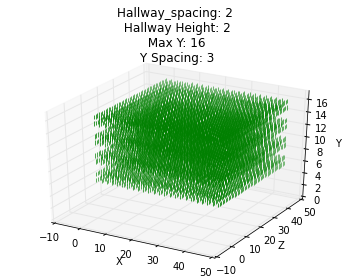

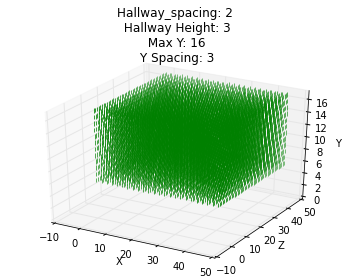

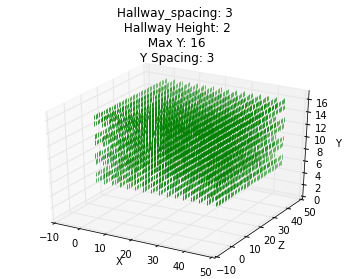

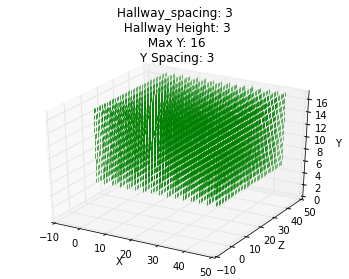

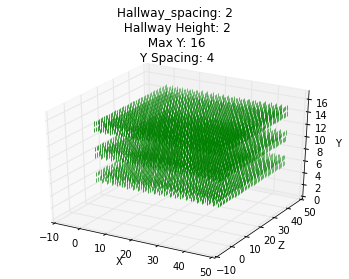

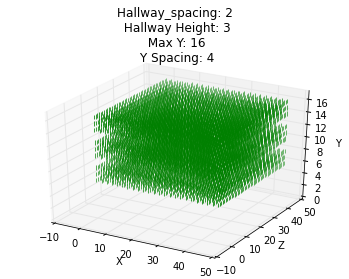

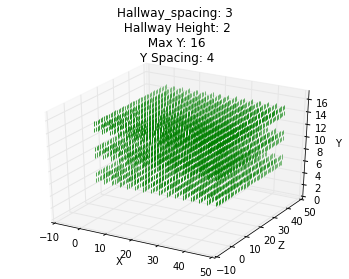

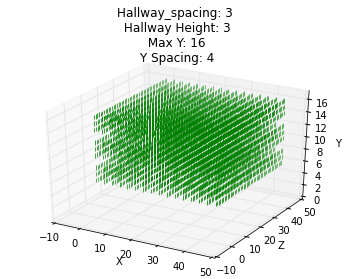

In [6]:
class HallwayMining:
    def __init__(self, min_x, max_x, min_z, max_z, min_y, max_y):
        self.min_x = min_x
        self.max_x = max_x
        self.min_z = min_z
        self.max_z = max_z
        self.min_y = min_y
        self.max_y = max_y   

        
        
    def mine_hallway(self,
                     hallway_spacing, 
                     hallway_height, 
                     max_y_height, 
                     y_layer_spacing):
        ### mine path must fit in 48 x 48 space
        hallway = []
        for y_pattern in xrange(6, max_y_height, y_layer_spacing): 
            for x in xrange(0, 47, hallway_spacing):
                for z in xrange(0, 47):
                    for y in range(y_pattern, y_pattern + hallway_height):
                        hallway.append((x,z,y))
                        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        try:
            xs = [i[0] for i in hallway]
            zs = [j[1] for j in hallway]
            ys = [k[2] for k in hallway]
            ax.scatter(xs, zs, ys, color='green', marker='|')
            ax.set_zlim3d([0, 17])
            ax.set_title("Hallway_spacing: %r \n Hallway Height: %s \n Max Y: %s \n Y Spacing: %s"% (hallway_spacing, hallway_height, max_y_height, y_layer_spacing)) 
            ax.set_xlabel('X')
            ax.set_ylabel('Z')
            ax.set_zlabel('Y')
        except KeyError:
            print "keyerror"
            pass


                        
        hallway_ore_filter = {
#             'iron':0,
            'diamond':0,
#             'redstone':0,
#             'coal':0,
            'gold':0,
        }

        blocks, mining_pathway = block_handler.simulation(
            x1=self.min_x,
            x2=self.max_x,
            z1=self.min_z,
            z2=self.max_z,
            y1=self.min_y,
            y2=self.max_y,
            relative_path=hallway,
            ore_count=hallway_ore_filter,
            world=world,
            plot=True)

        multi_index_labels = [
            'Hallway Spacing',
            'Hallway Height',
            'Y Spacing',
    #         'type'
        ]
        multi_index_columns = [
            hallway_spacing,
            hallway_height,
            y_layer_spacing,
    #         ['pathway or ore']
        ]

        ore_columns = pd.MultiIndex.from_arrays(
            multi_index_columns,
            names=multi_index_labels
        )
        path_columns = pd.MultiIndex.from_arrays(
            multi_index_columns,
            names=multi_index_labels,
        )

        temp_ores = pd.DataFrame(
            blocks.values(),
            index=[
                [i[0] for i in blocks.keys()],
                [i[1] for i in blocks.keys()],
                [i[2] for i in blocks.keys()],
            ],
            columns=ore_columns)


        temp_pathway = pd.DataFrame(
            ['pathway' for i in mining_pathway],
            index=[
                [i[0] for i in mining_pathway],
                [i[1] for i in mining_pathway],
                [i[2] for i in mining_pathway],
            ],
            columns=path_columns
        )
    #     temp = pd.concat([temp_ores, temp_pathway], join='outer', axis=1)
    #     return temp
        return temp_ores, temp_pathway



    def mine_hallway_configurations(self,
                                    y_layer_spacings,
                                    hallway_spacings,
                                    hallway_heights,
                                    hallways_per_sample,):
        df_sample_size = pd.DataFrame()
        df_ores = pd.DataFrame()
        df_paths = pd.DataFrame()
        for y_layer_spacing in y_layer_spacings:
            for hallway_spacing in hallway_spacings:
                for hallway_height in hallway_heights:
                    temp_ores, temp_pathway = self.mine_hallway(
                        hallway_spacing=hallway_spacing, 
                        hallway_height=hallway_height,
                        max_y_height=16, 
                        y_layer_spacing=y_layer_spacing
                    )
                    sample_size_coordinates = pd.Series(
                        {
                        'x_sample_size':hallway_spacing * hallways_per_sample,
                        'z_sample_size':hallway_spacing * hallways_per_sample,
                        'y_sampe_size':y_layer_spacing
                        },
                        name='%r, %r, %r' % (
                            hallway_spacing,
                            hallway_height,
                            y_layer_spacing
                        )
                    )


        #             df = pd.concat([df, temp], join='outer', axis=1)
                    df_ores = pd.concat([df_ores, temp_ores], join='outer', axis=1)            
                    df_paths = pd.concat([df_paths, temp_pathway], join='outer', axis=1)
                    df_sample_size = df_sample_size.append(sample_size_coordinates)

                    df_ores = df_ores.sortlevel(2).sortlevel(1).sortlevel(0)
                    df_paths = df_paths.sortlevel(2).sortlevel(1).sortlevel(0)
                    df_sample_size = df_sample_size.sort()
        return df_ores, df_paths, df_sample_size

    def cases_sample_sum_counts(self, df_ores):
        newdf_ores = pd.DataFrame()
        for column in df_ores:
            x_sample_size = int(df_sample_size['x_sample_size'][str([column[0], 
                                                                     column[1], 
                                                                     column[2]]
                                                                   ).strip(']').strip('[')])
            z_sample_size = int(df_sample_size['z_sample_size'][str([column[0], 
                                                                     column[1], 
                                                                     column[2]]
                                                                   ).strip(']').strip('[')])
            for x_subset in range(self.min_x * 16, 
                                  self.max_x * 16, 
                                  x_sample_size):
                for z_subset in range(self.min_z * 16, 
                                      self.max_z * 16, 
                                      z_sample_size):
                    temp_append = df_ores.loc[
                    (
                        slice(x_subset, x_subset + x_sample_size - 1),
                        slice(z_subset, z_subset + z_sample_size - 1),                    
                    ),
                    :
                ][column[0]][column[1]][column[2]].value_counts()
                    temp_append.name = '%s, %s, %s' % (column[0], 
                                                       column[1], 
                                                       column[2])

                    newdf_ores = newdf_ores.append(temp_append)
        newdf_ores = newdf_ores.sort()
        return newdf_ores
    
hallway = HallwayMining(min_x=-10, 
                        max_x=10, 
                        min_z=-10, 
                        max_z=10, 
                        min_y=0, 
                        max_y=1)
    
df_ores, df_paths, df_sample_size = hallway.mine_hallway_configurations(
    y_layer_spacings=[3, 4],
    hallway_spacings=[2, 3],
    hallway_heights=[2, 3],
    hallways_per_sample=4
)
%time

newdf_ores = hallway.cases_sample_sum_counts(df_ores)
newdf_path_count = hallway.cases_sample_sum_counts(df_paths)

path_size_mean = newdf_path_count.groupby(newdf_path_count.index).mean()
newdf_ores_count = newdf_ores.groupby(newdf_ores.index).count()




## Mean, STDEV, Sample Count, Confidence

In [50]:
individual_sample_efficiencies = newdf_ores.divide(newdf_path_count['pathway'], axis='index')
newdf_ores_sample_count = pd.DataFrame(newdf_ores.index.value_counts(), 
             columns=['sample_size']
            ).sort()
efficiency_means = individual_sample_efficiencies.fillna(0).groupby(
    individual_sample_efficiencies.index
).mean()
efficiency_stdevs = individual_sample_efficiencies.fillna(0).groupby(
    individual_sample_efficiencies.index
).std()
efficiency_stderrors = efficiency_stdevs.divide(
    np.sqrt(newdf_ores_sample_count['sample_size']),
    axis='index'
)
confidence_margins_95 = pd.DataFrame()
confidence = .95
for i in efficiency_stderrors.index:
    temp = efficiency_stderrors.loc[i] * sp.stats.t.ppf(
        (1 + confidence)/2.,
        newdf_ores_sample_count['sample_size'].loc[i]
    )
    confidence_margins_95 = confidence_margins_95.append(temp)
confidence_margins_95
upper_bound = efficiency_means + confidence_margins_95
lower_bound = efficiency_means - confidence_margins_95
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [51]:
efficiency_means

,diamond,gold
"2, 2, 3",0.002296,0.002956
"2, 2, 4",0.002719,0.003689
"2, 3, 3",0.001784,0.002268
"2, 3, 4",0.002103,0.002727
"3, 2, 3",0.003154,0.004063
"3, 2, 4",0.003530,0.004894
"3, 3, 3",0.002584,0.003231
"3, 3, 4",0.002925,0.003797


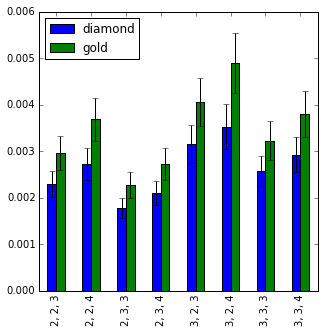

In [48]:
efficiency_means.plot(kind='bar',
                      yerr=confidence_margins_95, 
                      figsize=(5,5))


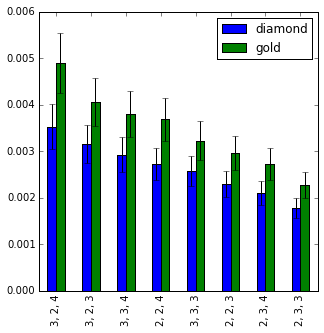

In [49]:
diamond_efficiency_sorted = efficiency_means.sort(['diamond'], ascending=False, axis='index')
diamond_efficiency_sorted.plot(kind='bar',
                      yerr=confidence_margins_95, 
                      figsize=(5,5))

$$Confidence\, Interval = SE * t_{.95}$$

Here I use 'scipy.stats.t.ppf' to calculate this.  
    

# from here on is incomplete

### Path Type: Branch Leaf: leaf_spacing = 4, branch_spacing = 12

In [ ]:
branch_leaf = []
leaf_spacing = 4
branch_spacing = 12
for y_pattern in xrange(0, 4, 3): 
    for x in xrange(6, 42, branch_spacing):
        for z in xrange(2, 48):
            for y in range(6 + y_pattern,8 + y_pattern):
                branch_leaf.append((x,z,y))
    ### leaves
        for z in xrange(3, 48, leaf_spacing): 
            for x_2 in xrange(x, x + 6): 
                for y in range(7 + y_pattern,8 + y_pattern):
                    branch_leaf.append((x_2,z,y))
            for x_3 in xrange(x - 5, x): 
                for y in range(7 + y_pattern,8 + y_pattern):
                    branch_leaf.append((x_3,z,y))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

try:
    xs = [i[0] for i in branch_leaf]
    zs = [j[1] for j in branch_leaf]
    ys = [k[2] for k in branch_leaf]
    ax.scatter(xs, zs, ys, color='green', marker='|')
    ax.set_zlim3d([0, 17])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
except KeyError:
    pass

branch_leaf_ore_filter = {
    'iron':0,
    'diamond':0,
    'redstone':0,
#    'coal':0,
    'gold':0,
}
blocks, branch_leaf = block_handler.simulation(
    x1=-15,
    x2=15,
    z1=-15,
    z2=15,
    y1=0,
    y2=1,
    relative_path=branch_leaf,
    ore_count=branch_leaf_ore_filter,
    world=world)
ore_counts = pd.DataFrame([branch_leaf_ore_filter], index=['branch_leaf lf_space=4 br_space=12'])
branch_leaf_efficiency = ore_counts / len(branch_leaf) * 100
branch_leaf_efficiency
print len(blocks)
index_x = [i[0] for i in blocks.keys()]
index_z = [i[1] for i in blocks.keys()]
index_y = [i[2] for i in blocks.keys()]
pandasblocks['branch_leaf lf_space=4 br_space=12'] = pd.DataFrame(blocks.values(), [index_x, index_z, index_y])

### Comparison of Paths' Performance

In [ ]:
all_efficiencies = pd.concat([branch_leaf_lf3_br12_efficiency,
                    branch_leaf_efficiency, 
                    branch_leaf_lf5_br12_efficiency,
                    branch_leaf_lf6_br12_efficiency,
                    branch_leaf_lf7_br12_efficiency,
                    one_by_two_efficiency, 
                    one_by_two_4space_efficiency,
                             ])
all_efficiencies

In [ ]:
branch_leaf_efficiencies = pd.concat([branch_leaf_lf3_br12_efficiency,
                    branch_leaf_efficiency, 
                    branch_leaf_lf5_br12_efficiency,
                    branch_leaf_lf6_br12_efficiency,
                    branch_leaf_lf7_br12_efficiency,
                    ])
branch_leaf_efficiencies

In [ ]:
branch_leaf_efficiencies.sort().T.plot(kind='bar', title="Branch_Leaf_Mining_Efficiencies", figsize=(10,7))

In [ ]:
one_by_two_efficiencies = pd.concat([one_by_two_efficiency, 
                    one_by_two_4space_efficiency,
                    one_by_two_6space_efficiency,
                    one_by_two_8space_efficiency,
                    one_by_two_10space_efficiency,])
one_by_two_efficiencies

In [ ]:
one_by_two_efficiencies.sort().T.plot(kind='bar', title="1 x 2 spacing optimization", figsize=(10,7))

### Compare the Two Top Performers for Diamonds

In [ ]:
top_diamond_performers = pd.concat([branch_leaf_efficiency, one_by_two_efficiency])
top_diamond_performers.diamond.plot(kind='bar', title='Diamonds', grid=True)
top_diamond_performers.T.plot(kind='bar')

##### Send to plot.ly

In [ ]:
top_diamond_performers.T.index.tolist()

In [ ]:
branch_leaf_data = top_diamond_performers.T['branch_leaf lf_space=4 br_space=12'].tolist()
one_by_two = top_diamond_performers.T['one_by_two_3space'].tolist()

In [ ]:
trace1 = Bar(
    x=top_diamond_performers.T.index.tolist(),
    y=branch_leaf_data,
    name='branch_leaf'
)

trace2 = Bar(
    x=top_diamond_performers.T.index.tolist(),
    y=one_by_two,
    name='one_by_two'
)

data = Data([trace1, trace2])
layout = Layout(
    barmode='group'
)
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='test1234')